<div class="alert alert-block alert-success">  
<h1><center><strong>Time Series Problem ⏰</strong></center></h1>

#### If this helped in your learning, then please **UPVOTE** – as they are the source of motivation!

#### **What are time series forecasting and analysis?**

Time series forecasting is a set of methods in statistics and data science to predict some variables that develop and change over time. The underlying intention of time series forecasting is determining how target variables will change in the future by observing historical data from the time perspective, defining the patterns, and yielding short or long-term predictions on how change occurs – considering the captured patterns.


Time series problems, on the other hand, are always time-dependent and we usually look at four main components: seasonality, trends, cycles, and irregular components.


![](https://content.altexsoft.com/media/2017/07/medicine-sales-graph.png.webp)



The graph above is a clear example of how trends and seasons work.

Trends. The trend component describes how the variable – drug sales in this case – changes over long periods of time. We see that the sales revenues of antidiabetic drugs have substantially increased during the period from the 1990s to 2010s.

Seasons. The seasonal component showcases each year’s wave-like changes in sales patterns. Sales were increasing and decreasing seasonally. Seasonal series can be tied to any time measurement, but these periods of time always have a fixed length and succession. We can consider monthly or quarterly patterns for sales in midsize or small eCommerce, or track micro-interactions across a day.

Cycles. Cycles are long-term patterns that have a waveform and recurring nature similar to seasonal patterns but with variable length, they don’t have a fixed time period. For example, business cycles have recognizable elements of growth, recession, and recovery. But the cycles themselves stretch in time differently for a given country throughout its history.

Irregularities. Irregular components appear due to unexpected events, like cataclysms, or are simply representative of noise in the data.

<div class="alert alert-info">  
<h3><strong>Import Libraries 📃</strong></h3>
</div>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import matplotlib.patches as patches
# import pmdarima as pm
# from pmdarima.arima import auto_arima

In [2]:
sales_train = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
shops = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')
items = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
items_cat = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')


In [3]:
sales_train.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


In [4]:
items.head(2)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76


In [5]:
items_cat.head(2)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1


In [6]:
shops.head(2)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1


**First Merge these Tables by using Join technique.**

In [7]:
item_merged = pd.merge(items,items_cat,how='inner')
shop_merged = pd.merge(sales_train,shops,on='shop_id')
train_data = pd.merge(item_merged,shop_merged,on='item_id')

In [8]:
train_data.head()

,item_name,item_id,item_category_id,item_category_name,date,date_block_num,shop_id,item_price,item_cnt_day,shop_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,01.09.2014,20,54,58.0,1.0,"Химки ТЦ ""Мега"""
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,24.08.2014,19,54,58.0,1.0,"Химки ТЦ ""Мега"""
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,12.11.2014,22,54,58.0,1.0,"Химки ТЦ ""Мега"""
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,05.07.2014,18,54,100.0,1.0,"Химки ТЦ ""Мега"""
4,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,26.08.2014,19,54,58.0,1.0,"Химки ТЦ ""Мега"""


# Remove Duplicated Rows

In [9]:
train_data.drop(train_data[train_data.duplicated()].index,axis=0,inplace=True)

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935843 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   item_name           object 
 1   item_id             int64  
 2   item_category_id    int64  
 3   item_category_name  object 
 4   date                object 
 5   date_block_num      int64  
 6   shop_id             int64  
 7   item_price          float64
 8   item_cnt_day        float64
 9   shop_name           object 
dtypes: float64(2), int64(4), object(4)
memory usage: 246.4+ MB


There are only one Item which have the price of negative 1. it can be an outlier so we will remove it with most occurring value.

In [11]:
train_data[train_data.item_price < 0]

,item_name,item_id,item_category_id,item_category_name,date,date_block_num,shop_id,item_price,item_cnt_day,shop_name
954789,"DmC Devil May Cry [PS3, русские субтитры]",2973,19,Игры - PS3,15.05.2013,4,32,-1.0,1.0,"Москва ТЦ ""Серебряный Дом"""


In [12]:
train_data.loc[954789,'item_price'] = train_data['item_price'].mode()[0]

**Groupby function use to group the data with the packet of date_block_num,shop_id,item_id and count the item_cnt_day to find out item count in month**

In [13]:
temp_data = train_data.groupby(['date_block_num','shop_name','item_name','item_category_name']).agg({'item_cnt_day' : 'count'})
temp_data.reset_index(inplace=True)
temp_data = temp_data.set_index('date_block_num')

In [14]:
temp_data.head(2)

,shop_name,item_name,item_category_name,item_cnt_day
date_block_num,,,,
0,"!Якутск Орджоникидзе, 56 фран",1+1,Кино - DVD,4
0,"!Якутск Орджоникидзе, 56 фран",1+1 (BD),Кино - Blu-Ray,3


**Checking Which item sold the most**

<AxesSubplot:title={'center':'Shops for most item Count'}, xlabel='shop_name'>

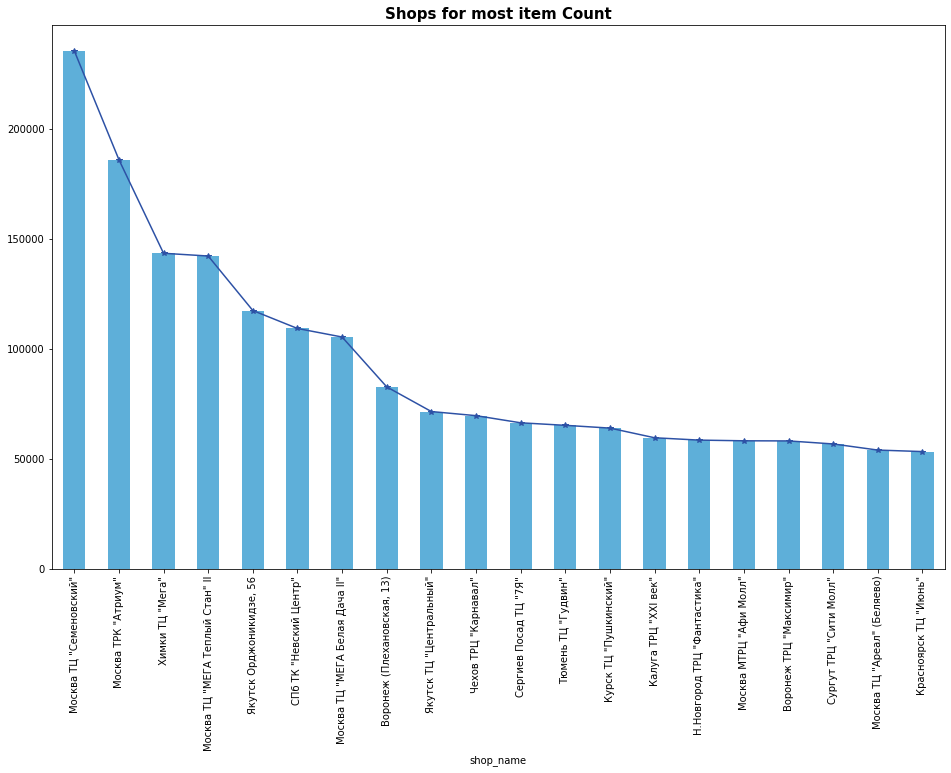

In [15]:
plt.figure(figsize=(16,10))
plt.title('Shops for most item Count',weight='bold',fontsize=15)
temp_data.groupby('shop_name')['item_cnt_day'].sum().sort_values(ascending=False)[0:20].plot(kind='line',marker='*',color="#2D51A5")
temp_data.groupby('shop_name')['item_cnt_day'].sum().sort_values(ascending=False)[0:20].plot(kind='bar',color="#5EAFD9")

**Checking which shop sold the items most**

Text(3.6, 24000, 'Most Sold Item')

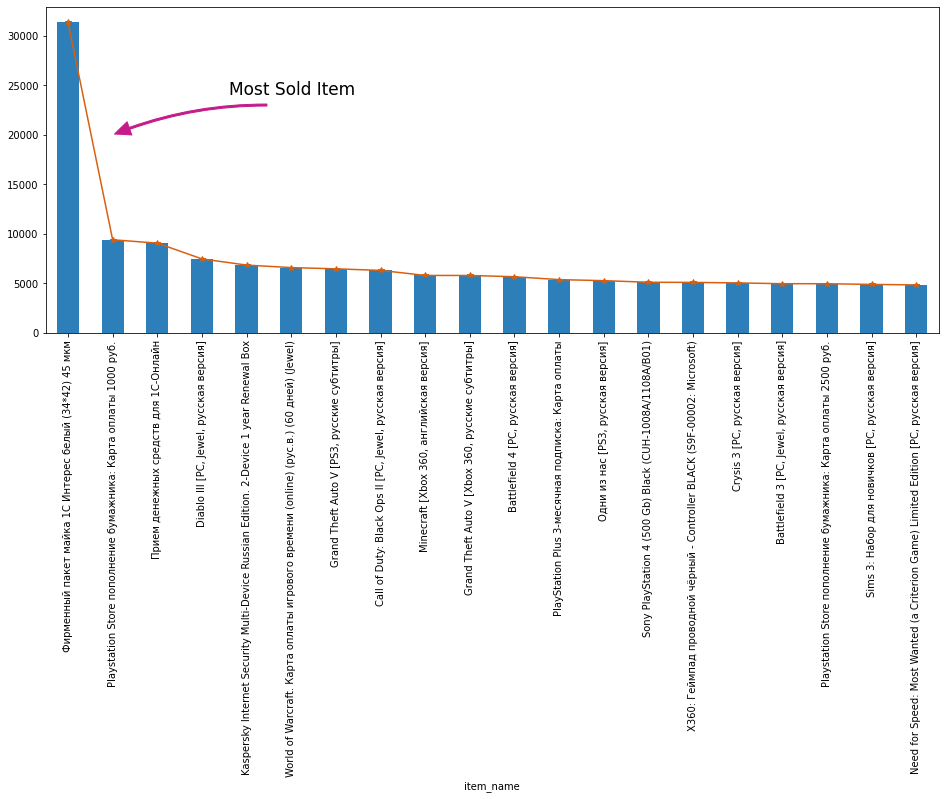

In [16]:
plt.figure(figsize=(16,6))

temp_data.groupby('item_name')['item_cnt_day'].sum().sort_values(ascending=False)[0:20].plot(kind='line',marker='*',color='#d95f0e')
temp_data.groupby('item_name')['item_cnt_day'].sum().sort_values(ascending=False)[0:20].plot(kind='bar',color='#2c7fb8')

arrow_data = 'Simple,tail_width=2,head_width=14,head_length=16'
kw = dict(arrowstyle=arrow_data,color='#c51b8a')
arr = patches.FancyArrowPatch((4.5,23000),(1.0,20000),connectionstyle='arc3,rad=.10',**kw)
plt.gca().add_patch(arr)
plt.text(x=3.6,y=24000,s="Most Sold Item",color='black',size=17)

**Our Month Column is in form of Str. so first convert it into datetime form**

In [17]:
train_data['date'] = pd.to_datetime(train_data['date'],format='%d.%m.%Y')
train_data['Month'] = train_data['date'].dt.to_period('M')
train_data['Month'] = train_data['Month'].astype(str)

**Now we have all the Months+year column named Month, now applying groupby to count the item_cnt_day for whole month**

In [18]:
temp_data = train_data.groupby(['shop_id','item_id','Month']).agg({'item_cnt_day' : 'sum'})
temp_data.reset_index(inplace=True)
temp_data = temp_data.set_index('Month')

In [19]:
temp_data.rename(columns = {'item_cnt_day' : 'item_cnt_month'},inplace=True)
temp_data.head()

,shop_id,item_id,item_cnt_month
Month,,,
2013-02,0,30,31.0
2013-02,0,31,11.0
2013-01,0,32,6.0
2013-02,0,32,10.0
2013-01,0,33,3.0


**Checking which Month with year selling the Most**

<AxesSubplot:xlabel='Month'>

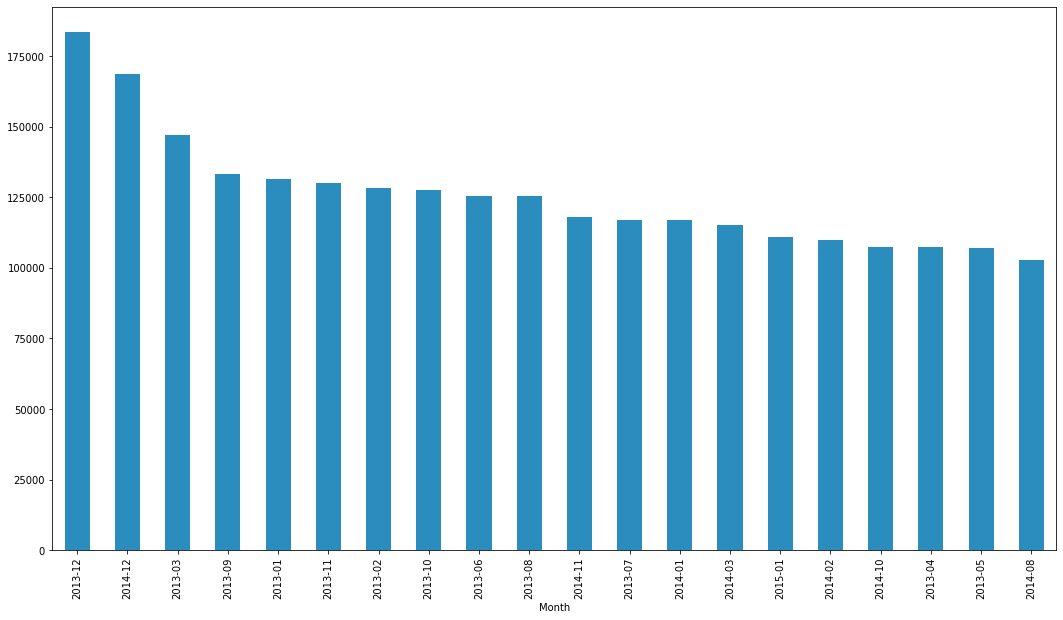

In [20]:
plt.figure(figsize=(18,10))
temp_data.groupby('Month')['item_cnt_month'].sum().sort_values(ascending=False)[:20].plot(kind='bar',color='#2b8cbe')

<AxesSubplot:xlabel='Month'>

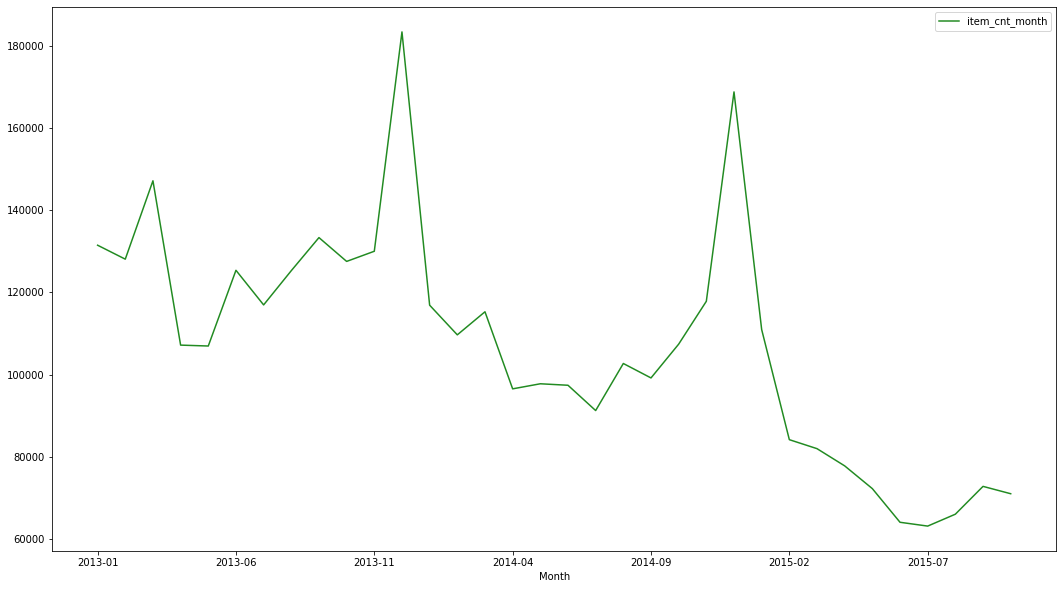

In [21]:
plt.figure(figsize=(18,10))
temp_data.groupby('Month')['item_cnt_month'].sum().plot(legend=True,color='forestgreen')

**So we determine that Last Months like November, December with different years have most selling**

In [22]:
temp_data.reset_index(inplace=True)
temp_data.tail(5)

,Month,shop_id,item_id,item_cnt_month
1609119,2015-04,59,22164,2.0
1609120,2015-07,59,22164,1.0
1609121,2013-10,59,22167,1.0
1609122,2013-12,59,22167,2.0
1609123,2014-06,59,22167,1.0


In [23]:
X = temp_data.iloc[:,:-1]
y = temp_data.iloc[:,-1:]
le = LabelEncoder()
X['Month']= le.fit_transform(X['Month'])
X

,Month,shop_id,item_id
0,1,0,30
1,1,0,31
2,0,0,32
3,1,0,32
4,0,0,33
...,...,...,...
1609119,27,59,22164
1609120,30,59,22164
1609121,9,59,22167
1609122,11,59,22167


In [24]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
x_train.head()

,Month,shop_id,item_id
212066,2,13,8635
671328,11,28,6112
1469969,27,56,14308
1542939,23,57,20734
1141202,25,45,21922


**Using XGBRegressor with different hyperparameter tuning**

In [25]:
xg = xgb.XGBRegressor(base_score=0.5,
                      n_estimators=400,
                      min_child_weight=1,
                     max_depth=7,
                     learning_rate=0.1,
                     booster='gbtree',
                     tree_method='exact',
                     reg_alpha=0,
                     subsample=0.5,
                     validate_parameters=1,
                     colsample_bylevel=1,
                     colsample_bynode=1,
                     colsample_bytree=1,
                     gamma=0)
xg.fit(x_train,y_train)
xg.score(x_test,y_test)

0.6070369565892766

In [26]:
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')
test.set_index('ID',inplace=True)
test['Month'] = 34

In [27]:
pred = xg.predict(test)
test['item_cnt_month'] = (pred[0]*len(test))/len(test)

In [28]:
sub = pd.read_csv('../input/competitive-data-science-predict-future-sales/sample_submission.csv')
test.reset_index(inplace=True)
sub = test.drop(['shop_id','item_id','Month'],axis=1)

In [29]:
sub.to_csv('submission.csv',index=False)
subb = pd.read_csv('./submission.csv')
subb.head()

,ID,item_cnt_month
0,0,0.898744
1,1,0.898744
2,2,0.898744
3,3,0.898744
4,4,0.898744
